In [42]:
import pandas as pd
import numpy as np
import acessos as ac
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
query = '''

select
cd_cpf
, cs.ds_status
, gr.ds_schooling
, o.ds_cbo_group  
, gr.vl_renda_declarada
, max(gc.vl_current_limit) as vl_current_limit
, max(vl_pix_cash_out_credit) as vl_pix_cash_out_credit
, max(nr_pix_cash_in + nr_pix_cash_out_account + nr_pix_cash_out_credit) as nr_trans_pix
, max(nr_ted_cash_in + nr_ted_cash_out) as nr_trans_ted
, max(nr_ted_willers_cash_out + nr_ted_willers_cash_in) as nr_ted_willers
from customer_analytics_zone.ca_analitico_basao_crm b
inner join customer_curated_zone.cashout_credito_model_score cs on cs.id_customer = b.id_customer 
left join customer_curated_zone.ca_book_cliente cli on (cli.cpf = b.cd_cpf)
--left join customer_curated_zone.ca_book_cobranca cob on (cli.id_customer  = cob.id_customer and cob.cd_yearmonth = 202308)
left JOIN customer_curated_zone.ca_book_features_conta AS co ON (cli.id_customer  = co.id_customer)
left join customer_curated_zone.ca_book_gestao_carteira as gc on (gc.id_customer = b.id_customer and gc.cd_yearmonth = 202308)
left JOIN customer_curated_zone.ca_book_growth AS gr ON (cli.id_customer  = gr.id_customer)
left join customer_curated_zone.ca_dict_occupations o on (o.ds_occupation  = gr.ds_occupation)
WHERE vl_renda_declarada IS NOT NULL
group by 1,2,3,4,5
order by rand()
limit 500000

'''

In [44]:
df = ac.df_athena('flavia-costa', query)

In [45]:
df['vl_renda_declarada'].value_counts()

2000.00      55877
3000.00      38677
1500.00      33524
2500.00      32072
0.00         31217
             ...  
1674.81          1
532500.00        1
2463.00          1
5324.00          1
12723.00         1
Name: vl_renda_declarada, Length: 10504, dtype: int64

In [46]:
df.head()

,cd_cpf,ds_status,ds_schooling,ds_cbo_group,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
0,11052820743,d. nao_propensos,COMPLETE_HIGH_SCHOOL,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS,1303.33,390.0,20.11,5.0,0.0,0.0
1,00705333183,d. nao_propensos,INCOMPLETE_HIGH_SCHOOL,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS,1800.00,2400.0,0.00,3.0,0.0,0.0
2,14191291475,d. nao_propensos,COMPLETE_HIGH_SCHOOL,AUTÔNOMOS,1300.00,500.0,0.00,156.0,6.0,0.0
3,53749024820,d. nao_propensos,COMPLETE_HIGH_SCHOOL,"PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS,...",2500.00,2500.0,0.00,43.0,0.0,0.0
4,03866000154,d. nao_propensos,INCOMPLETE_HIGHER_EDUCATION,AUTÔNOMOS,2000.00,100.0,0.00,5.0,0.0,0.0


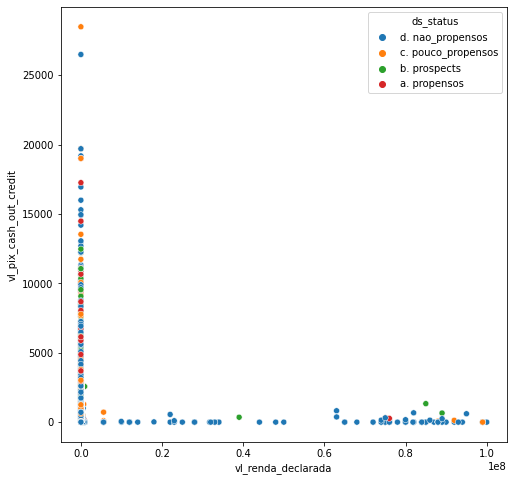

In [88]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x="vl_renda_declarada", y="vl_pix_cash_out_credit", hue="ds_status")
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from sklearn.decomposition import PCA


features_cluster = ['vl_renda_declarada','vl_current_limit','vl_pix_cash_out_credit','nr_trans_pix', 'nr_trans_ted', 'nr_ted_willers']

base_cluster = df[features_cluster]

for i in base_cluster.columns:
    base_cluster[i] = base_cluster[i].fillna(0.0)

# pca = PCA(n_components=0.95) #Explicar 95% da variância
# pca.fit(base_cluster)
# base_cluster_pca = pca.transform(base_cluster)

# componentes = base_cluster_pca.shape[1]
# print(componentes)



/tmp/ipykernel_1059239/4075818560.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster[i] = base_cluster[i].fillna(0.0)


In [49]:
pca = PCA(n_components=2) #Explicar 95% da variância
pca.fit(base_cluster)
base_cluster_pca = pca.transform(base_cluster)

componentes = base_cluster_pca.shape[1]

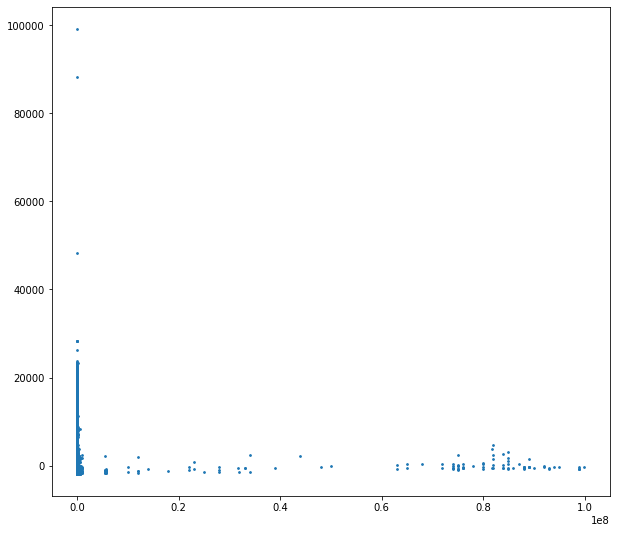

In [50]:

plt.figure(figsize=(10,9))
plt.scatter(base_cluster_pca[:, 0], base_cluster_pca[:, 1], s=3, cmap='Spectral')


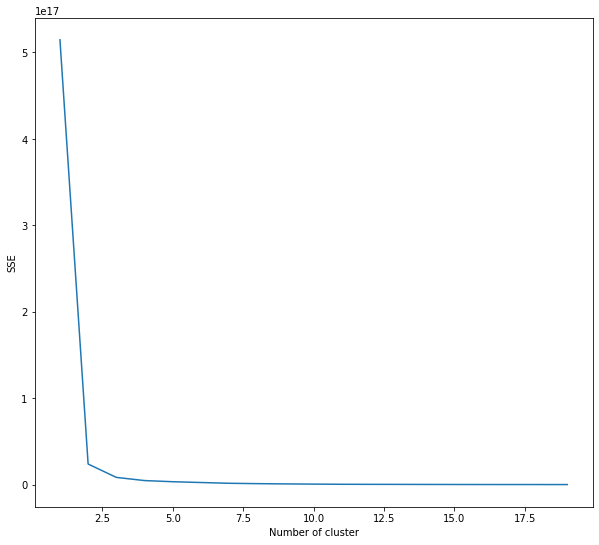

In [51]:


#AVALIANDO MELHOR NR DE CLUSTERS
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()




In [52]:
#DEFININDO NR DE CLUSTERS
k = 4

#NORMALIZAÇÃO
scaler = StandardScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)


#ALGORITMO
kmeans = KMeans(n_clusters = k, random_state=0).fit(data_input_scaled)


cluster = kmeans.predict(data_input_scaled)
base_cluster['cluster'] = cluster
df['cluster'] = cluster


print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts())
print(df['cluster'].value_counts(normalize = True))


---------------VOLUMETRIA ------------------
0    457839
2     25524
3     16562
1        75
Name: cluster, dtype: int64
0    0.915678
2    0.051048
3    0.033124
1    0.000150
Name: cluster, dtype: float64


/tmp/ipykernel_1059239/1624675736.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster['cluster'] = cluster


---------------MEDIAS POR CLUSTER ------------
---------------MEDIAS POR CLUSTER GRÁFICO ------------


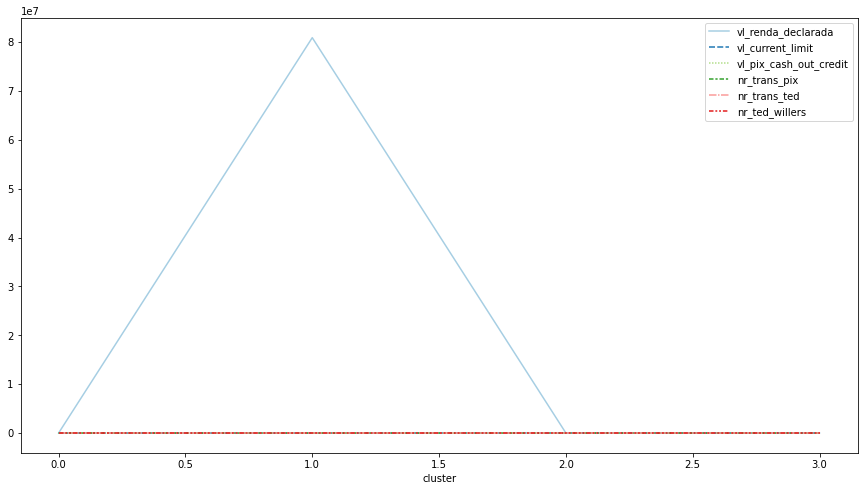

In [53]:

print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
df[totalfeat].groupby('cluster').mean()
print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
plt.figure(figsize=(15,8))
sns.lineplot(data = df[totalfeat].groupby('cluster').mean(), palette = 'Paired')
plt.show()


---------------MEDIAS POR CLUSTER GRÁFICO ------------


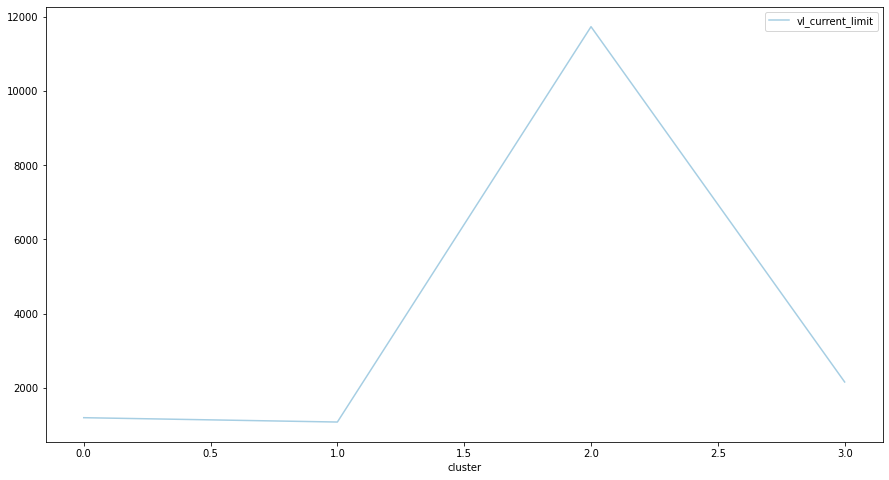

In [54]:
print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
plt.figure(figsize=(15,8))
sns.lineplot(data = df[['vl_current_limit', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

---------------MEDIAS POR CLUSTER GRÁFICO ------------


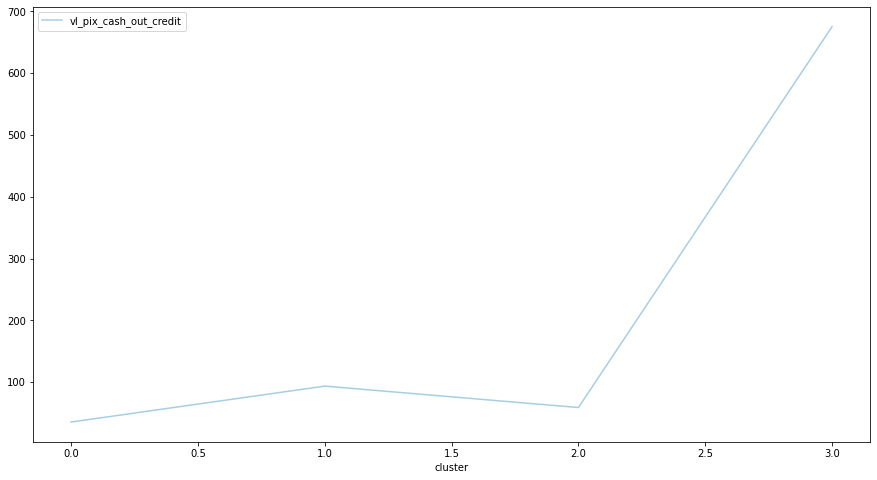

In [55]:
print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
plt.figure(figsize=(15,8))
sns.lineplot(data = df[['vl_pix_cash_out_credit', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

---------------MEDIAS POR CLUSTER GRÁFICO ------------


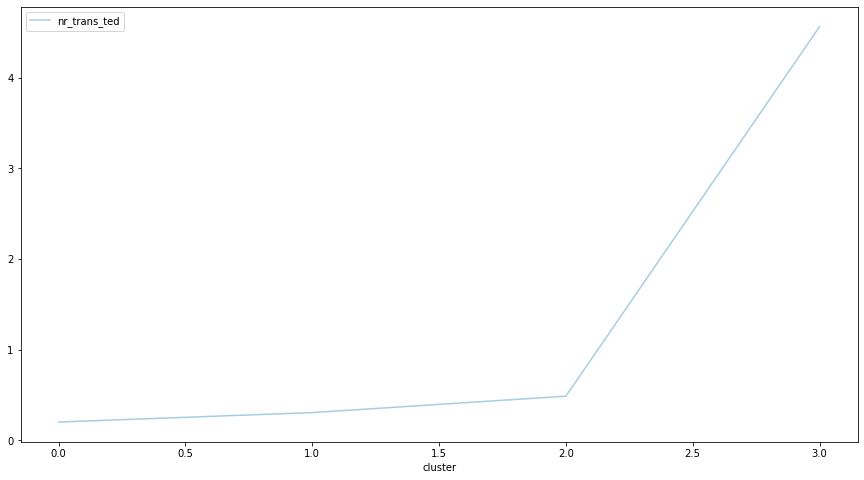

In [56]:
print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
plt.figure(figsize=(15,8))
sns.lineplot(data = df[['nr_trans_ted', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

In [57]:
pd.crosstab(df.cluster, df.ds_status, normalize = 'index')

ds_status,a. propensos,b. prospects,c. pouco_propensos,d. nao_propensos
cluster,,,,
0,0.015388,0.011253,0.031000,0.942360
1,0.013333,0.026667,0.053333,0.906667
2,0.096223,0.079259,0.106488,0.718030
3,0.077889,0.039428,0.097995,0.784688


In [58]:
df[totalfeat].groupby('cluster').mean()

,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
cluster,,,,,,
0,4.514367e+03,1195.802722,35.600329,13.426241,0.202633,0.000100
1,8.090687e+07,1078.800000,93.701600,24.400000,0.306667,0.000000
2,1.813244e+03,11736.109348,59.057347,8.432866,0.487830,0.006674
3,3.040946e+03,2158.311798,675.060575,92.239403,4.561043,0.040937


In [59]:
df[totalfeat].groupby('cluster').median()

,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
cluster,,,,,,
0,2000.0,700.0,0.00,6.0,0.0,0.0
1,81983300.0,600.0,0.00,10.0,0.0,0.0
2,0.0,10800.0,0.00,3.0,0.0,0.0
3,2000.0,1000.0,60.29,55.0,4.0,0.0


In [60]:
df_ocupacao = pd.crosstab(df.ds_cbo_group, df.cluster, normalize = 'index')

In [61]:
df_ocupacao = df_ocupacao.reset_index()

In [67]:
df_ocupacao.columns = ['ds_cbo_group', 'cl0 - pouco propenso', 'cl1 - Outlier', 'cl2 - Alto limite', 'cl3 - Alto cashout']

In [69]:
df_ocupacao.sort_values(by = 'cl2 - Alto limite', ascending=False).head(10)

,ds_cbo_group,cl0 - pouco propenso,cl1 - Outlier,cl2 - Alto limite,cl3 - Alto cashout
9,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,0.843724,0.000000,0.118130,0.038146
4,"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEI...",0.887054,0.000000,0.090179,0.022768
6,OUTROS,0.883315,0.000139,0.082317,0.034229
5,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",0.903774,0.000158,0.063064,0.033005
7,"PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS,...",0.912228,0.000125,0.061325,0.026323
3,ESTUDANTES,0.908291,0.000075,0.061288,0.030346
10,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS,0.916993,0.000096,0.055796,0.027115
1,AUTÔNOMOS,0.907009,0.000119,0.052951,0.039921
0,APOSENTADOS,0.929133,0.000189,0.046613,0.024064
11,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",0.920701,0.000192,0.044256,0.034852


In [70]:
df_ocupacao.sort_values(by = 'cl3 - Alto cashout', ascending=False).head(10)

,ds_cbo_group,cl0 - pouco propenso,cl1 - Outlier,cl2 - Alto limite,cl3 - Alto cashout
1,AUTÔNOMOS,0.907009,0.000119,0.052951,0.039921
9,TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...,0.843724,0.000000,0.118130,0.038146
8,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P...",0.930517,0.000251,0.031921,0.037311
12,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...,0.936578,0.000079,0.027487,0.035856
11,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",0.920701,0.000192,0.044256,0.034852
6,OUTROS,0.883315,0.000139,0.082317,0.034229
5,"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTE...",0.903774,0.000158,0.063064,0.033005
3,ESTUDANTES,0.908291,0.000075,0.061288,0.030346
2,DONAS DE CASA,0.965642,0.000838,0.004469,0.029050
10,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS,0.916993,0.000096,0.055796,0.027115


## Olhando só os propensos

In [100]:
df2 = df.query('ds_status == "a. propensos" | ds_status == "c. pouco_propensos" | ds_status == "b. prospects"')

In [101]:
len(df2)

37160

In [102]:
base_cluster = df2[features_cluster]

In [103]:
base_cluster

,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
17,0.0,12600.0,0.00,56.0,1.0,0.0
19,0.0,9300.0,0.00,0.0,0.0,0.0
25,0.0,3000.0,8.79,67.0,3.0,0.0
28,0.0,15000.0,NaN,NaN,NaN,NaN
46,0.0,7200.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
499974,0.0,13600.0,NaN,NaN,NaN,NaN
499985,0.0,0.0,0.00,2.0,0.0,0.0
499988,0.0,3900.0,0.00,6.0,0.0,0.0
499989,1000.0,6700.0,0.00,1.0,0.0,0.0


In [104]:
for i in base_cluster.columns:
    base_cluster[i] = base_cluster[i].fillna(0.0)

/tmp/ipykernel_1059239/200311391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster[i] = base_cluster[i].fillna(0.0)


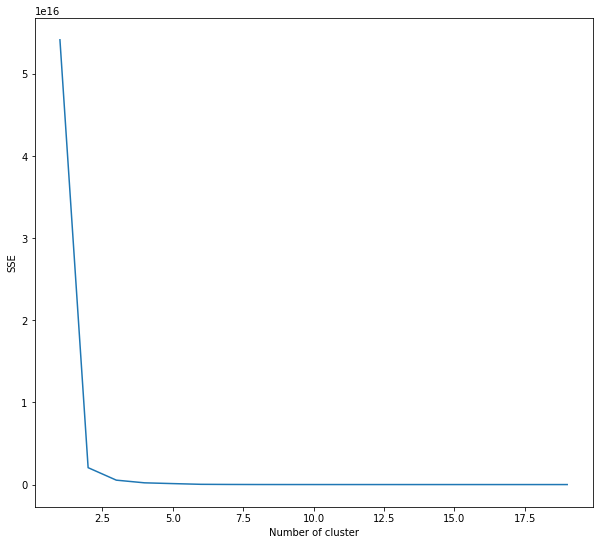

In [105]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [106]:
#DEFININDO NR DE CLUSTERS
k = 5

#NORMALIZAÇÃO
scaler = StandardScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)


#ALGORITMO
kmeans = KMeans(n_clusters = k, random_state=0).fit(data_input_scaled)


cluster = kmeans.predict(data_input_scaled)
base_cluster['cluster'] = cluster
df2['cluster'] = cluster

/tmp/ipykernel_1059239/3845444194.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster['cluster'] = cluster
/tmp/ipykernel_1059239/3845444194.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cluster'] = cluster


In [107]:
print("---------------VOLUMETRIA ------------------")
print(df2['cluster'].value_counts())
print(df2['cluster'].value_counts(normalize = True))

---------------VOLUMETRIA ------------------
0    28365
1     6885
3     1832
4       71
2        7
Name: cluster, dtype: int64
0    0.763321
1    0.185280
3    0.049300
4    0.001911
2    0.000188
Name: cluster, dtype: float64


In [125]:
df2 = df2.query('cluster != 4 & cluster != 2')

In [126]:
df2[totalfeat].groupby('cluster').mean()

,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
cluster,,,,,,
0,4016.287871,1589.791962,212.096445,25.142645,0.453966,0.002675
1,561.300925,12624.688308,102.016490,7.158925,0.720251,0.009395
3,2538.243215,3835.026747,1744.345884,94.056769,5.849345,0.020197


In [127]:
df2[totalfeat].groupby('cluster').median()

,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
cluster,,,,,,
0,1360.0,900.0,50.32,16.0,0.0,0.0
1,0.0,12400.0,0.00,2.0,0.0,0.0
3,400.0,1700.0,793.11,50.0,5.0,0.0


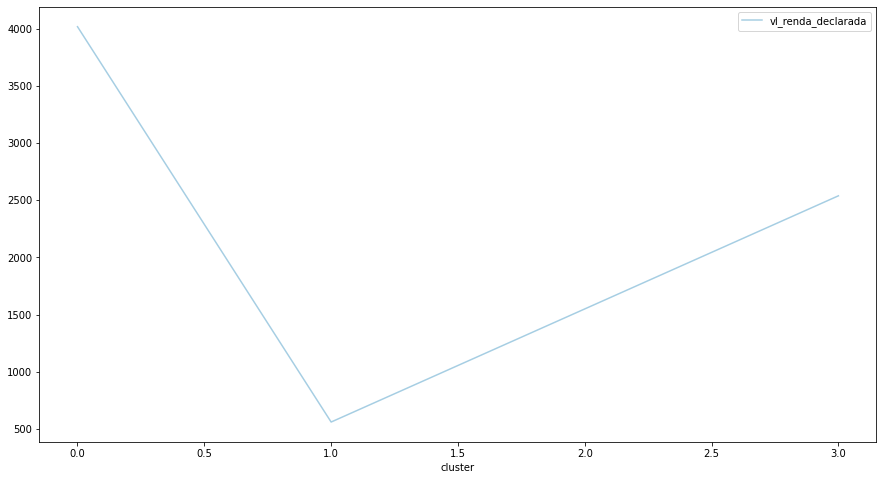

In [128]:

plt.figure(figsize=(15,8))
sns.lineplot(data = df2[['vl_renda_declarada', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

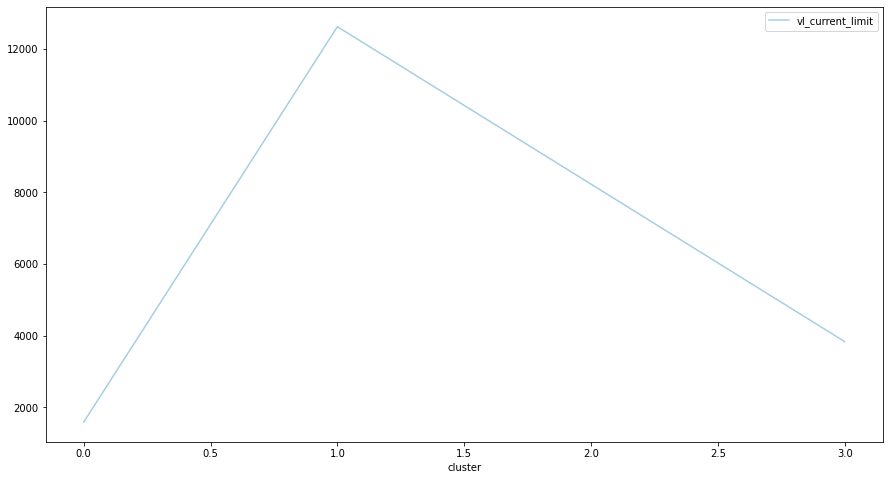

In [129]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df2[['vl_current_limit', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

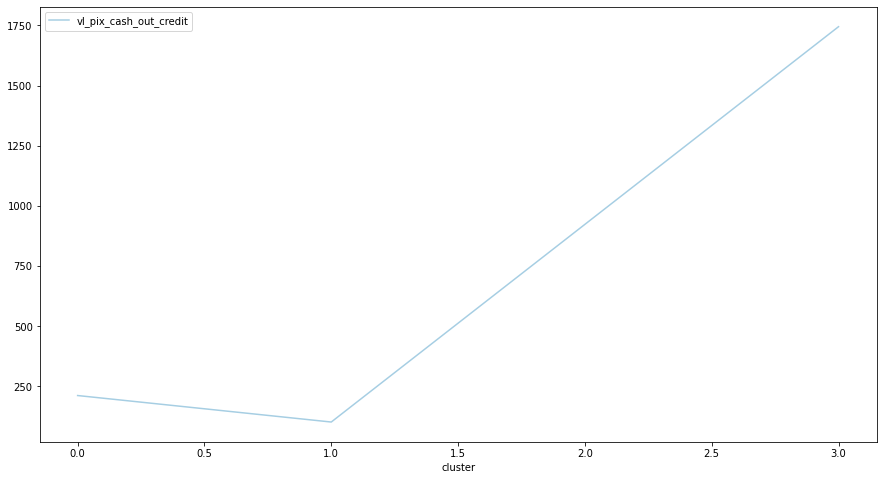

In [130]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df2[['vl_pix_cash_out_credit', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

In [131]:
df2.ds_cbo_group.value_counts()

AUTÔNOMOS                                                                                                       8511
TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉRCIO EM LOJAS E MERCADOS                                          7357
TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS                                                                       5201
PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS, HUMANAS E DAS ARTES                                              4025
MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES DE ORGANIZAÇÕES DE INTERESSE PÚBLICO E DE EMPRESAS, GERENTES    2595
OUTROS                                                                                                          2242
TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA                                                              1670
TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUTENÇÃO                                                             1401
ESTUDANTES                                                      

In [132]:
df2['flag_autonomos'] = np.where(df2.ds_cbo_group == "AUTÔNOMOS", 'Sim', 'Não')

In [133]:
df2['flag_big_shot'] = np.where(df2.ds_cbo_group == "MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES DE ORGANIZAÇÕES DE INTERESSE PÚBLICO E DE EMPRESAS, GERENTES", 'Sim', 'Não')

In [134]:
df_ocupacao = pd.crosstab(df2.ds_cbo_group, df2.cluster, normalize = 'index')

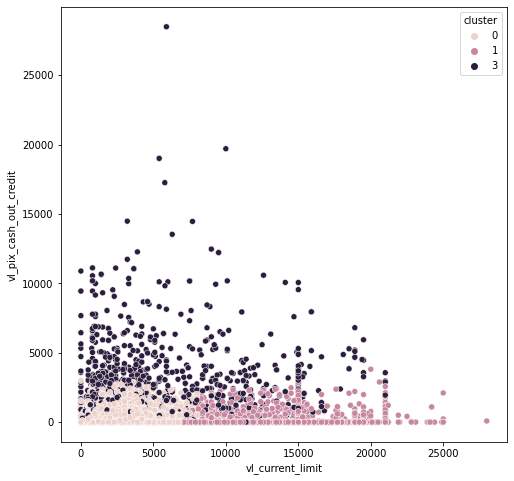

In [135]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="vl_current_limit", y="vl_pix_cash_out_credit", hue="cluster")
plt.show()

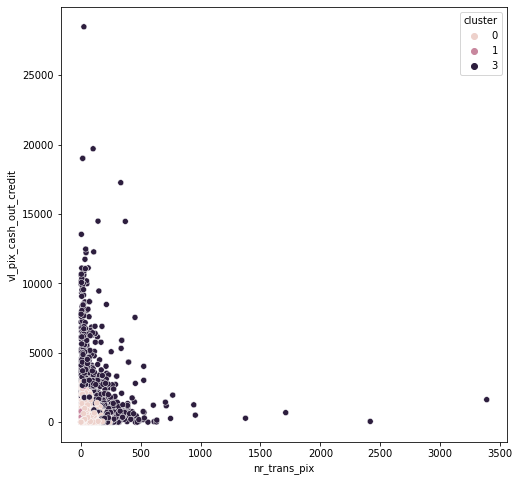

In [136]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="nr_trans_pix", y="vl_pix_cash_out_credit", hue="cluster")
plt.show()

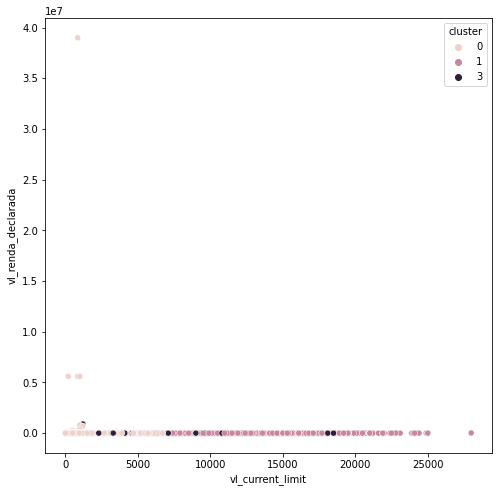

In [137]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="vl_current_limit", y="vl_renda_declarada", hue="cluster")
plt.show()

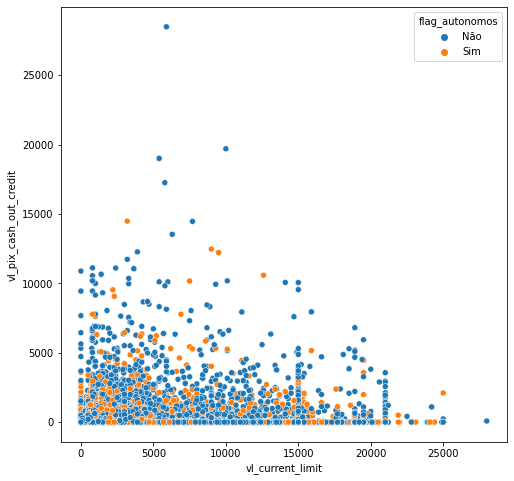

In [138]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="vl_current_limit", y="vl_pix_cash_out_credit", hue="flag_autonomos")
plt.show()

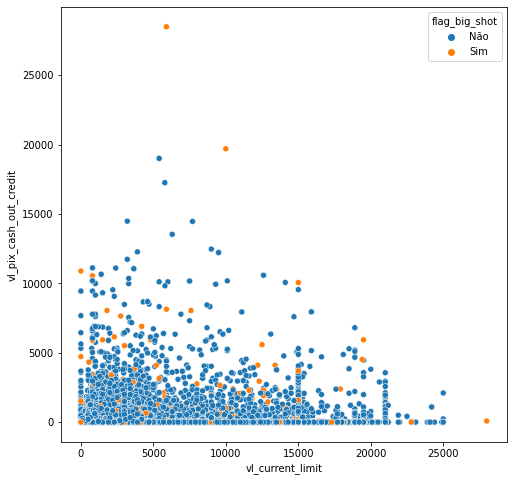

In [139]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="vl_current_limit", y="vl_pix_cash_out_credit", hue="flag_big_shot")
plt.show()

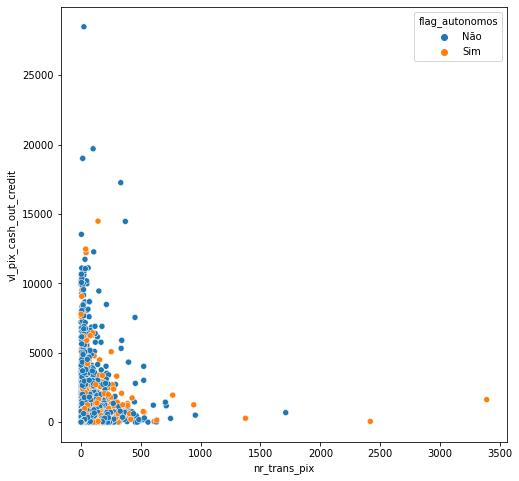

In [140]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="nr_trans_pix", y="vl_pix_cash_out_credit", hue="flag_autonomos")
plt.show()

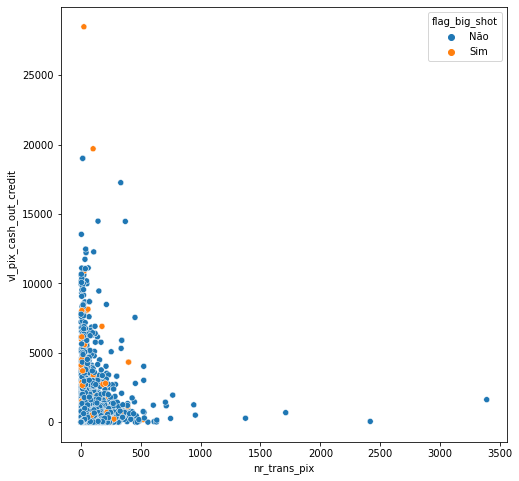

In [141]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df2, x="nr_trans_pix", y="vl_pix_cash_out_credit", hue="flag_big_shot")
plt.show()

In [142]:
'''
0 -> Super limite com frequencia ocasional
2 -> Limite mediano, alta frequencia pix e alto valor de pix cashout
3 -> 

'''


df_ocupacao

cluster,0,1,3
ds_cbo_group,,,
APOSENTADOS,0.742254,0.218310,0.039437
AUTÔNOMOS,0.759253,0.185525,0.055223
DONAS DE CASA,0.969945,0.008197,0.021858
ESTUDANTES,0.714400,0.228000,0.057600
"MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEIROS MILITARES",0.703488,0.255814,0.040698
"MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES DE ORGANIZAÇÕES DE INTERESSE PÚBLICO E DE EMPRESAS, GERENTES",0.750289,0.196146,0.053565
OUTROS,0.716771,0.239518,0.043711
"PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS, HUMANAS E DAS ARTES",0.741863,0.211180,0.046957
"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA",0.828743,0.125749,0.045509
